# Information Retrival Project

### Group members:
1. Dang Hoang Khang NGUYEN - M1 AI
2. Ahmed Nazar - M1 DS
3. Md Naim Hassan Saykat - M1 AI

## Introduction: 
- Explanation of the problem


# Task 1: Pre-ranking

# 0.0 Set Up

## 0.1 Imports - !pip install <package_name> if necessary

In [1]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')  # For lemmatization
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khanghoang0902/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/khanghoang0902/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/khanghoang0902/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/khanghoang0902/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 0.2 Helper Functions

In [3]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type):
    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]
    cnt = 0
    texts = []
    ids_to_remove = []

    for doc in corpus:
        try:
            if text_type == 'title':
                text = doc['Content']['title']
            elif text_type == 'abstract':
                text = doc['Content']['pa01']
            elif text_type == 'claim1':
                text = doc['Content']['c-en-0001']
            elif text_type == 'claims':
                claims = [v for k, v in doc['Content'].items() if k.startswith('c-en-')]
                text = ' '.join(claims)
            elif text_type == 'description':
                desc = [v for k, v in doc['Content'].items() if k.startswith('p')]
                text = ' '.join(desc)
            elif text_type == 'fulltext':
                text = ' '.join(doc['Content'].values())
            elif text_type == 'claims+desc':
                claims = [v for k, v in doc['Content'].items() if k.startswith('c-en-')]
                desc = [v for k, v in doc['Content'].items() if k.startswith('p')]
                text = ' '.join(claims + desc)
            elif text_type == 'tac':
                title = doc['Content'].get('title', '')
                abstract = doc['Content'].get('pa01', '')
                claims = [v for k, v in doc['Content'].items() if k.startswith('c-en-')]
                text = ' '.join([title, abstract] + claims)
            else:
                raise ValueError("Invalid text type")
            
            texts.append(text)
        except:
            ids_to_remove.append(doc['Application_Number'] + doc['Application_Category'])
            cnt += 1

    if cnt > 0:
        print(f"{cnt} documents without {text_type} text removed.")

    # Remove IDs for docs that failed
    for id_ in ids_to_remove[::-1]:
        idx = app_ids.index(id_)
        del app_ids[idx]

    return [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks

# 1.0 Load Datasets

In [4]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique

In [5]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)

mapping_dict = get_mapping_dict(mapping_dataset_df)

In [6]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The..."
...,...,...,...,...
6826,3741587,2020-11-25,A1,{'title': 'AUTO-LOCATION USING TIRE MOUNTED SY...
6827,3693248,2020-08-12,A1,{'title': 'HOLE COVER AND STEERING SYSTEM INCL...
6828,3628962,2020-04-01,A1,{'title': 'SYSTEM AND METHOD FOR MEASURING CLE...
6829,3620899,2020-03-11,A1,{'title': 'TOUCH SCREEN AND DISPLAY APPARATUS'...


In [7]:
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...
...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en..."
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...


In [8]:
mapping_dataset_df

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [9]:
mapping_dict

{'3712070A1': ['3354576A1'],
 '3675165A1': ['3336831A2'],
 '3599626A1': ['2453448A1'],
 '3705201A1': ['2468433A2'],
 '3628210A1': ['3369366A1'],
 '3637504A1': ['2482368A1'],
 '3758169A1': ['2575411A1'],
 '3597767A1': ['2226127A1'],
 '3588532A1': ['2879156A1'],
 '3670817A1': ['3231978A1'],
 '3702079A1': ['3338931A1'],
 '3668068A1': ['3116204A1'],
 '3750631A1': ['3132851A1'],
 '3599082A1': ['2730353A1'],
 '3587089A1': ['3028845A1'],
 '3605854A1': ['3319239A1'],
 '3607862A1': ['2815685A1'],
 '3742402A1': ['3361724A2'],
 '3705896A1': ['2743710A1'],
 '3587065A1': ['2689910A1'],
 '3739813A1': ['2584496A1'],
 '3624050A1': ['2887642A2'],
 '3719445A1': ['2778606A1'],
 '3599363A1': ['3486467A2'],
 '3747742A1': ['2783951A1'],
 '3742709A1': ['3101560A1'],
 '3667442A1': ['2808242A1'],
 '3670124A1': ['2826608A1'],
 '3715223A1': ['2815953A1'],
 '3686680A1': ['3435167A1'],
 '3723272A1': ['3076542A1'],
 '3674167A1': ['2447130A1'],
 '3689738A1': ['3263446A1'],
 '3606117A1': ['3267699A1'],
 '3670347A1': 

## 1.1 Take a look at the content

In [10]:
nonciting_dataset_df.loc[0].Content

{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',
 'c-en-0001': 'A vehicle support assembly, comprising: first and second tilting wheels (421A, 421B; 16, 16) disposed respectively at different lateral positions with respect to a longitudinal axis; a tilt-mechanism (431; 17) configured for supportively associating a vehicle body (402) from the tilting wheels (421A, 421B; 16, 16) to enable the vehicle body (402) to tilt substantially through a first tilt range with respect to a surface (428) on which the tilting wheels (421A, 421B; 16, 16) are disposed; a tilt-limiter (450, 550, 650) operably associated with the tilt-mechanism (431) to restrict the tilting of the vehicle body (402) to less than the first tilt range, and releasable to allow the tilting through the first tilt range; characterised in that the vehicle support assembly further comprises : an inclination sensor configured to sense an inclination of the vehicle (130, 430) with respect to the vertical at least when the vehicle is a

## 1.2 Create a column with the Title

In [11]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


# 1.3 Average title length

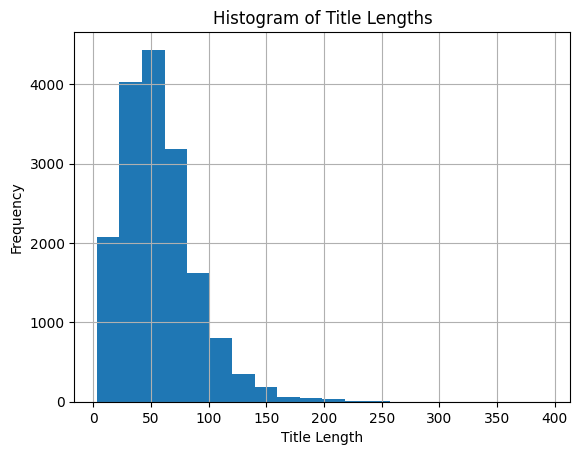

In [12]:
plt.hist(nonciting_dataset_df['Title'].str.len(), bins=20)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.grid(True)
plt.show()

## 1.4 Number of CITED patents per citing patent

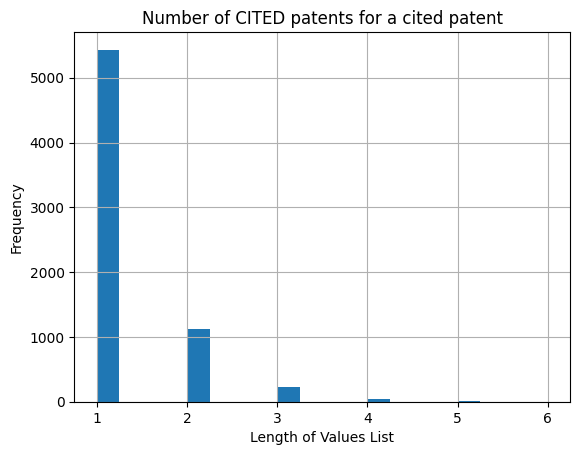

In [13]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a cited patent')
plt.grid(True)
plt.show()

## 1.4 Length comparision between different corpus

7811 documents without abstract text removed.


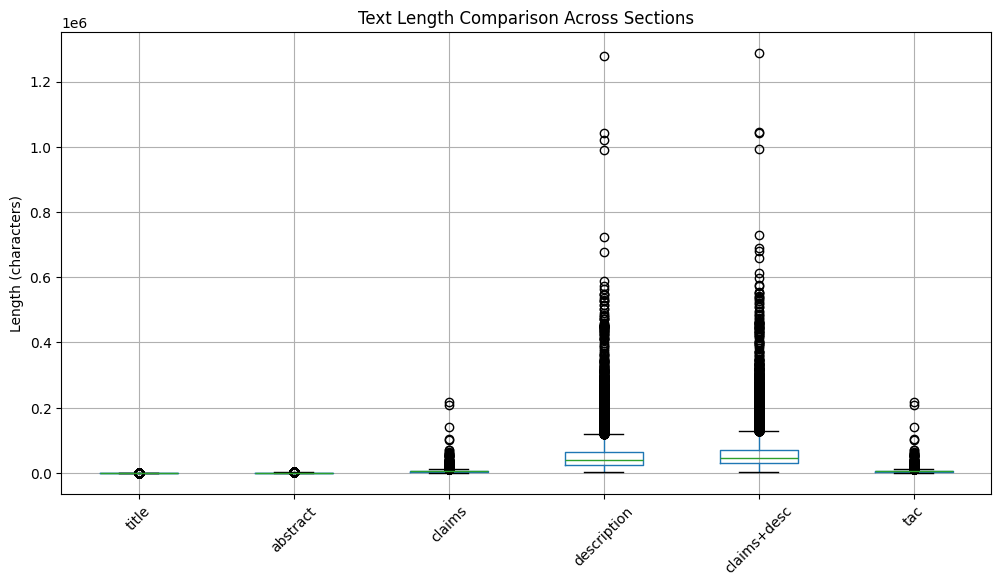

In [14]:
text_types = ['title', 'abstract', 'claims', 'description', 'claims+desc', 'tac']
length_data = {}

for text_type in text_types:
    corpus = create_corpus(json_nonciting, text_type)
    lengths = [len(doc['text']) for doc in corpus]
    length_data[text_type] = lengths

# Convert to DataFrame for visualization
import pandas as pd
length_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in length_data.items()]))
length_df.boxplot(figsize=(12, 6))
plt.title("Text Length Comparison Across Sections")
plt.ylabel("Length (characters)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 1.5 Text comparison between citing text and cited text

In [15]:
citing_dataset_df['CombinedID'] = citing_dataset_df['Application_Number'].astype(str) + citing_dataset_df['Application_Category']
nonciting_dataset_df['CombinedID'] = nonciting_dataset_df['Application_Number'].astype(str) + nonciting_dataset_df['Application_Category']

sample_id = list(mapping_dict.keys())[0]
cited_ids = mapping_dict[sample_id]

citing_row = citing_dataset_df[citing_dataset_df['CombinedID'] == sample_id]

if citing_row.empty:
    print(f"Citing patent {sample_id} not found.")
else:
    citing_content = citing_row.iloc[0]['Content']
    print("Citing Patent")
    print("Title:", citing_content.get("title", ""))
    print("Abstract:", citing_content.get("pa01", ""))
    print("Claim 1:", citing_content.get("c-en-0001", ""))

cited_rows = nonciting_dataset_df[nonciting_dataset_df['CombinedID'].isin(cited_ids)]

for _, row in cited_rows.iterrows():
    content = row['Content']
    print("\nCited Patent:", row['CombinedID'])
    print("Title:", content.get("title", ""))
    print("Abstract:", content.get("pa01", ""))
    print("Claim 1:", content.get("c-en-0001", ""))


Citing Patent
Title: SHOESTRING ENVIRONMENTAL CONTROL SYSTEM FOR AN AIRCRAFT
Abstract: An environmental control system (20) of an aircraft includes a compressing device (40) having a compressor (42) configured to receive a flow of a first medium and a turbine (44) configured to receive the flow of the first medium from the compressor and a flow of a second medium. The turbine (44) is arranged downstream from the compressor along a flow path of the first medium. A dehumidification system is arranged in fluid communication with the turbine and a bypass valve is operable configured to divert the flow of the first medium around the turbine and at least a portion of the dehumidification system.
Claim 1: An environmental control system (20) of an aircraft comprising: a compressing device (40) including a compressor configured to receive a flow of a first medium and a turbine configured to receive the flow of the first medium and a flow of a second medium, the turbine (44) being arranged down

# 2.0 TF-IDF

## 2.1 'Title' TF-IDF

Let's consider only the Title text for now

In [16]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_train = create_corpus(json_citing_train , 'title')
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
title_citing_train[:5]

[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'},
 {'id': '3694265A1',
  'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'},
 {'id': '3623522A1', 'text': 'LAUNDRY MACHINE AND CONTROL METHOD OF THE SAME'},
 {'id': '3611147A1',
  'text': 'CHEMICAL AND TOPOLOGICAL SURFACE MODIFICATION TO ENHANCE COATING ADHESION AND COMPATIBILITY'},
 {'id': '3640454A1', 'text': 'FUEL METERING SYSTEM'}]

### 2.1.1 Initalize TF-IDF

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_train, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of cited TF-IDF matrix: {tfidf_nonciting.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of cited TF-IDF matrix: (16837, 10000)


### 2.1.2 Get Cosine similarities

In [18]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16696119, ..., 0.        , 0.        ,
        0.04566338],
       ...,
       [0.        , 0.        , 0.01757464, ..., 0.        , 0.        ,
        0.01951692],
       [0.        , 0.        , 0.06885372, ..., 0.        , 0.0532077 ,
        0.07646317],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(6831, 16837))

### 2.1.3 Get Metrics

In [19]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_tfidf, 4))
print("Recall at 20:", round(recall_at_20_titles_tfidf, 4))
print("Recall at 50:", round(recall_at_50_titles_tfidf, 4))
print("Recall at 100:", round(recall_at_100_titles_tfidf, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.258
Recall at 20: 0.3197
Recall at 50: 0.4048
Recall at 100: 0.4668
Mean ranking: 62.3493
Mean average precision: 0.1521
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.2 'Claim1' TF-IDF

In [20]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
claim1_citing = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')
claim1_nonciting = create_corpus(json_nonciting, 'claim1')
claim1_citing[:5]

3 documents without claim1 text removed.


[{'id': '3650293A1',
  'text': 'Device (1) for controlling the braking of a trailer, comprising: - at least one control line (2) connectable to a source of a work fluid at a first pressure; - a braking line (3) connectable to the service braking system (4) of the trailer and communicating with said control line (2); - at least one additional line (5) connectable to a source of a work fluid at a second pressure; - at least one emergency line (6) connectable to said additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; - at least one discharge line (8) of the work fluid communicating with a collection tank (9); - first valve means operable between a braking position, wherein said additional line (5) is isolated from said discharge line (8), and an emergency position, wherein said additional line (5) is communicating with said discharge line (8);'},
 {'id': '3694265A1',
  'text': 'A method of wire

In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(claim1_citing, claim1_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23665 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of citedTF-IDF matrix: (16834, 10000)


In [22]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[5.04661656e-04, 1.73900411e-04, 9.13427156e-03, ...,
        6.36926300e-02, 1.25884114e-02, 8.31144550e-04],
       [3.50344752e-03, 1.02647772e-02, 1.97642245e-03, ...,
        3.87152669e-02, 3.48597889e-02, 3.07036422e-03],
       [4.65212764e-04, 5.25011925e-03, 1.19882192e-03, ...,
        4.45755219e-02, 8.73387271e-05, 1.25964771e-03],
       ...,
       [2.00192536e-02, 3.32487972e-04, 3.08010131e-03, ...,
        1.04950604e-02, 3.01811849e-02, 3.68682601e-04],
       [2.62873775e-02, 3.96316869e-02, 1.19304685e-02, ...,
        2.61634525e-02, 3.63858856e-02, 2.19432799e-02],
       [2.46252132e-04, 3.34637354e-03, 2.69667347e-03, ...,
        9.84004237e-04, 1.40196571e-03, 2.73248941e-02]],
      shape=(6831, 16834))

In [23]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.3435
Recall at 20: 0.419
Recall at 50: 0.5353
Recall at 100: 0.6163
Mean ranking: 50.4386
Mean average precision: 0.1981
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.3 'All Content' TF_IDF

In [24]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')
full_text_citing[:5]

[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (8), and an emergency position, wherein the additional line (5) is communicating with the discharge line (8); second valve means (17) positioned between the additio

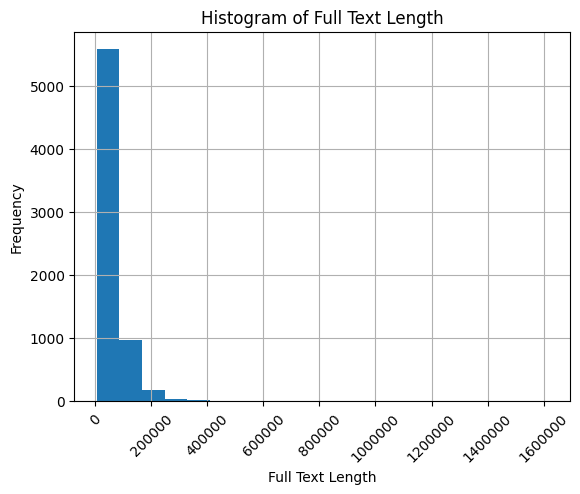

In [25]:
text_lengths = [len(item['text']) for item in full_text_citing]
plt.hist(text_lengths, bins=20)
plt.xlabel('Full Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Full Text Length')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()

In [26]:
#TOOD: Full Text TF_IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(full_text_citing, full_text_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of cited TF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of cited TF-IDF matrix: (16837, 10000)


In [27]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[0.1176446 , 0.02293664, 0.04019997, ..., 0.06120066, 0.01346326,
        0.02877317],
       [0.0161812 , 0.00724367, 0.03573286, ..., 0.02029483, 0.06300111,
        0.01532864],
       [0.01896814, 0.00902818, 0.02158792, ..., 0.03047271, 0.00894886,
        0.01892348],
       ...,
       [0.03545656, 0.02773704, 0.08512588, ..., 0.05737578, 0.02930984,
        0.04143333],
       [0.02869449, 0.01296327, 0.04428891, ..., 0.01805348, 0.02467116,
        0.03387486],
       [0.01974816, 0.00504043, 0.01245397, ..., 0.00634593, 0.00888053,
        0.02642236]], shape=(6831, 16837))

In [28]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.5449
Recall at 20: 0.6431
Recall at 50: 0.7632
Recall at 100: 0.8432
Mean ranking: 28.4859
Mean average precision: 0.3343
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.4 "Title, Abstract and Claims" TF-IDF

In [29]:
tac_citing_train = create_corpus(json_citing_train, 'tac')
tac_citing_test = create_corpus(json_citing_test, 'tac')
tac_nonciting = create_corpus(json_nonciting, 'tac')

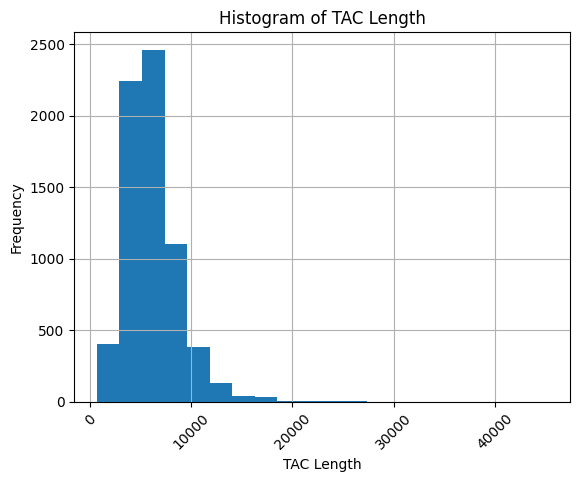

In [30]:
text_lengths = [len(item['text']) for item in tac_citing_train]
plt.hist(text_lengths, bins=20)
plt.xlabel('TAC Length')
plt.ylabel('Frequency')
plt.title('Histogram of TAC Length')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()

In [31]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(tac_citing_train, tac_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of cited TF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of cited TF-IDF matrix: (16837, 10000)


In [32]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[0.04841274, 0.02630107, 0.0252156 , ..., 0.05587585, 0.04537298,
        0.02162321],
       [0.00743631, 0.00303565, 0.01529276, ..., 0.02900199, 0.09392243,
        0.01778285],
       [0.00632401, 0.01170225, 0.01336001, ..., 0.032436  , 0.00386078,
        0.00980913],
       ...,
       [0.00975646, 0.00697845, 0.02765582, ..., 0.01882664, 0.02349524,
        0.01012983],
       [0.03207228, 0.0105223 , 0.03007662, ..., 0.01424369, 0.03370922,
        0.04522235],
       [0.00400467, 0.01278977, 0.01104138, ..., 0.00292892, 0.0042302 ,
        0.02358312]], shape=(6831, 16837))

In [33]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.4258
Recall at 20: 0.5175
Recall at 50: 0.6451
Recall at 100: 0.7356
Mean ranking: 39.8948
Mean average precision: 0.2554
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.5 "Claims and Descriptions" TF-IDF

In [34]:
claimsdesc_citing_train = create_corpus(json_citing_train, 'claims+desc')
claimsdesc_citing_test = create_corpus(json_citing_test, 'claims+desc')
claimsdesc_nonciting = create_corpus(json_nonciting, 'claims+desc')

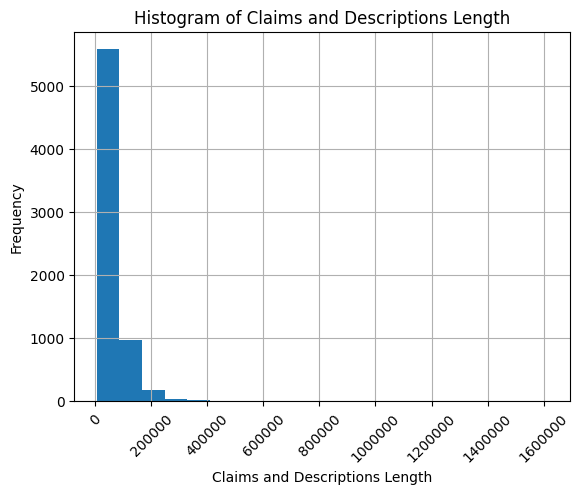

In [35]:
text_lengths = [len(item['text']) for item in claimsdesc_citing_train]
plt.hist(text_lengths, bins=20)
plt.xlabel('Claims and Descriptions Length')
plt.ylabel('Frequency')
plt.title('Histogram of Claims and Descriptions Length')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()

In [36]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(claimsdesc_citing_train, claimsdesc_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of cited TF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of cited TF-IDF matrix: (16837, 10000)


In [37]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[0.11759031, 0.02277487, 0.04033553, ..., 0.06149627, 0.01361739,
        0.02903245],
       [0.01621547, 0.00725518, 0.03574564, ..., 0.0203603 , 0.06336261,
        0.0153383 ],
       [0.01901618, 0.0090514 , 0.02152425, ..., 0.03058862, 0.00899417,
        0.0189699 ],
       ...,
       [0.03561192, 0.02785026, 0.08541893, ..., 0.0576857 , 0.02953665,
        0.04161738],
       [0.02877246, 0.01298957, 0.04432561, ..., 0.01811896, 0.02477018,
        0.03395651],
       [0.01986812, 0.00507022, 0.01247308, ..., 0.00638915, 0.00897497,
        0.02662803]], shape=(6831, 16837))

In [38]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.5448
Recall at 20: 0.6423
Recall at 50: 0.7628
Recall at 100: 0.8428
Mean ranking: 28.5438
Mean average precision: 0.3342
Number of patents measured: 6831
Number of patents not in the citation: 0


### Since claims and descriptions performance is very close to fulltext performance, I choose to work with claims and descriptsions for TF-IDF hyperparameter tuning

## 2.6 TF-IDF Tuning

In [39]:
# evaluation function to be called multiple times

def evaluate(citing, nonciting, tfidf_vectorizer, mapping_dict, label):
    tfidf_citing, tfidf_nonciting = create_tfidf_matrix(citing, nonciting, tfidf_vectorizer)
    cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)

    # Get top-k results
    k = 100
    top_k_rank = top_k_ranks(citing, nonciting, cosine_similarities, k=k)

    # Evaluation
    true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
    mean_rank = mean_ranking(true_labels, predicted_labels)
    mean_ap = mean_average_precision(true_labels, predicted_labels)
    recall_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
    recall_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
    recall_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
    recall_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

    print(f"\nResults for {label}")
    print("Recall@10:", round(recall_10, 4))
    print("Recall@20:", round(recall_20, 4))
    print("Recall@50:", round(recall_50, 4))
    print("Recall@100:", round(recall_100, 4))
    print("Mean Ranking:", round(mean_rank, 4))
    print("MAP:", round(mean_ap, 4))

    return {
        'label': label,
        'recall@10': recall_10,
        'recall@20': recall_20,
        'recall@50': recall_50,
        'recall@100': recall_100,
        'mean_rank': mean_rank,
        'map': mean_ap
    }


### 2.6.1 Tune max_features
- After 30000 features, the performance does not increase significantly, so we choose 30000 as max_features

In [40]:
settings = [10000, 30000, 50000]
results = []

for max_feat in settings:
    label = f"max_features={max_feat}"
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_feat)
    results.append(evaluate(claimsdesc_citing_train, claimsdesc_nonciting, vectorizer, mapping_dict, label))

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000

Results for max_features=10000
Recall@10: 0.5448
Recall@20: 0.6423
Recall@50: 0.7628
Recall@100: 0.8428
Mean Ranking: 28.5438
MAP: 0.3342
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 30000

Results for max_features=30000
Recall@10: 0.5649
Recall@20: 0.6613
Recall@50: 0.7742
Recall@100: 0.8505
Mean Ranking: 27.2603
MAP: 0.3539
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 50000

Results for max_features=50000
Recall@10: 0.5654
Recall@20: 0.6609
Recall@50: 0.7743
Recall@100: 0.8509
Mean Ranking: 27.2512
MAP: 0.3551


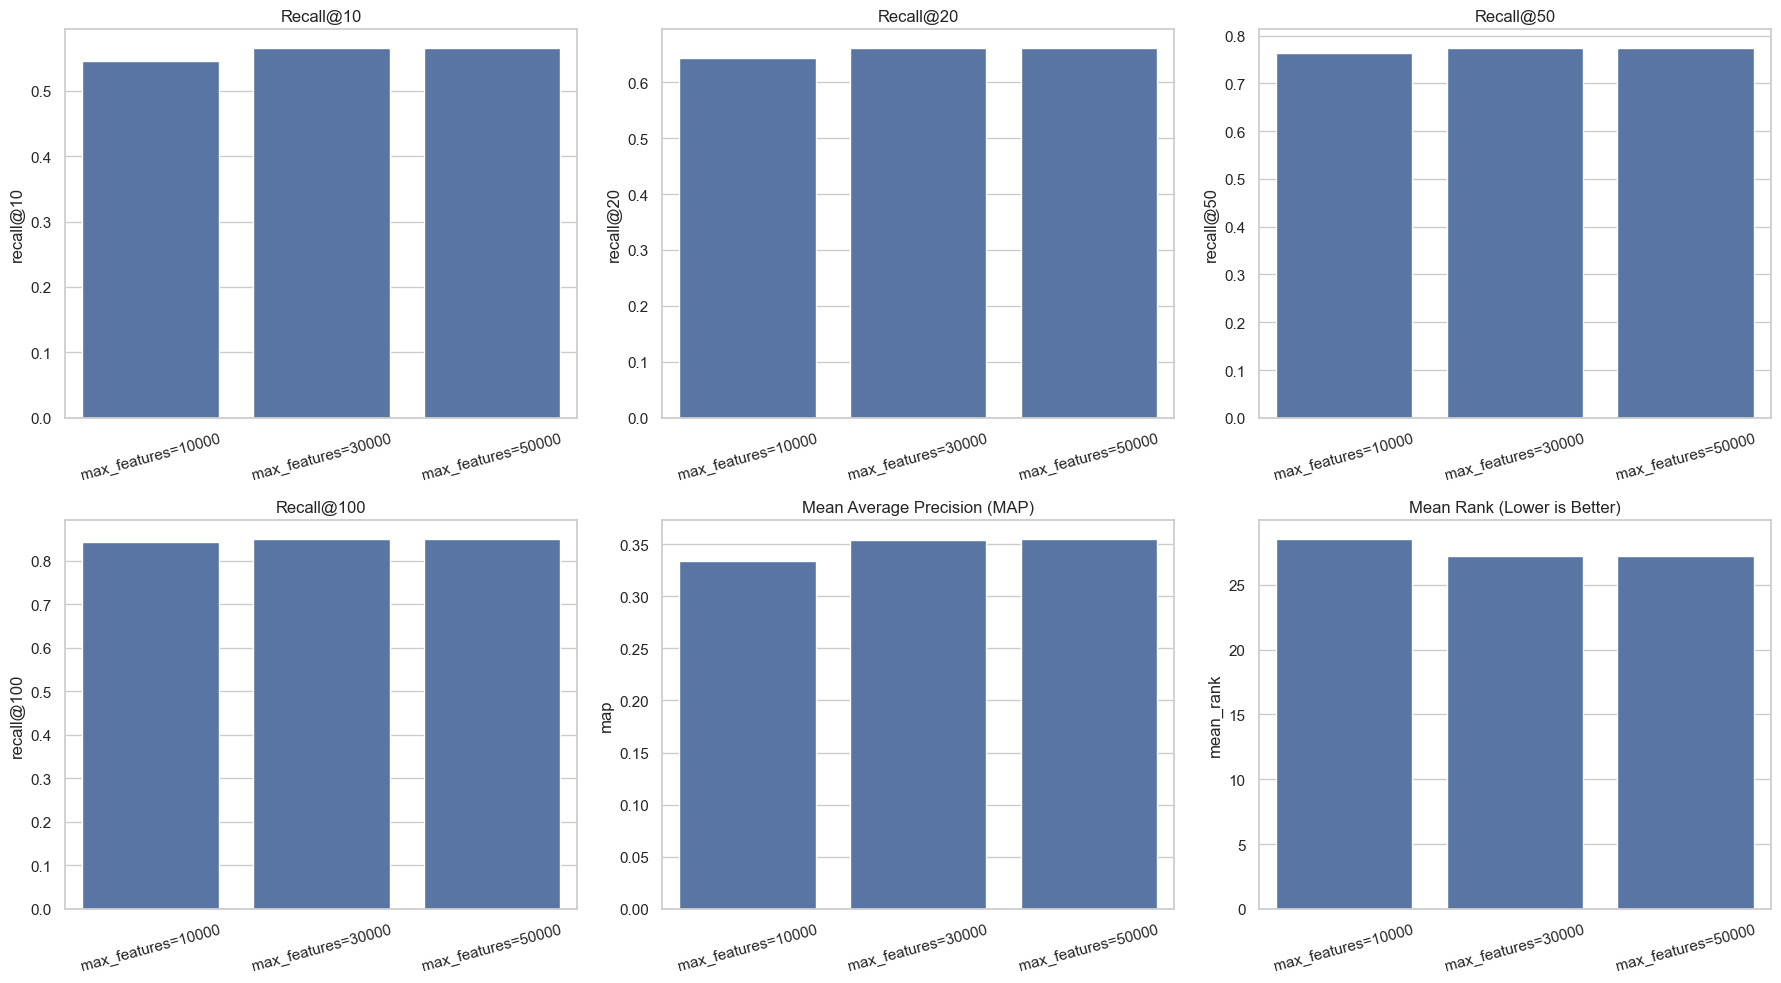

In [41]:
import seaborn as sns

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Set visual style
sns.set(style="whitegrid")

# Plot all metrics in subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Recall@10, 20, 50, 100
sns.barplot(data=df_results, x='label', y='recall@10', ax=axes[0, 0])
axes[0, 0].set_title('Recall@10')

sns.barplot(data=df_results, x='label', y='recall@20', ax=axes[0, 1])
axes[0, 1].set_title('Recall@20')

sns.barplot(data=df_results, x='label', y='recall@50', ax=axes[0, 2])
axes[0, 2].set_title('Recall@50')

sns.barplot(data=df_results, x='label', y='recall@100', ax=axes[1, 0])
axes[1, 0].set_title('Recall@100')

# MAP
sns.barplot(data=df_results, x='label', y='map', ax=axes[1, 1])
axes[1, 1].set_title('Mean Average Precision (MAP)')

# Mean Rank (Lower is better)
sns.barplot(data=df_results, x='label', y='mean_rank', ax=axes[1, 2])
axes[1, 2].set_title('Mean Rank (Lower is Better)')

# Adjust layout
for ax in axes.flat:
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 2.6.2 Tune sublinear_tf

In [42]:
settings = [True, False]
results = []

for flag in settings:
    label = f"sublinear_tf={flag}"
    vectorizer = TfidfVectorizer(stop_words='english', max_features=30000, sublinear_tf=flag)
    results.append(evaluate(claimsdesc_citing_train, claimsdesc_nonciting, vectorizer, mapping_dict, label))

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 30000

Results for sublinear_tf=True
Recall@10: 0.6883
Recall@20: 0.7618
Recall@50: 0.8447
Recall@100: 0.8963
Mean Ranking: 19.6564
MAP: 0.4637
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 30000

Results for sublinear_tf=False
Recall@10: 0.5649
Recall@20: 0.6613
Recall@50: 0.7742
Recall@100: 0.8505
Mean Ranking: 27.2603
MAP: 0.3539


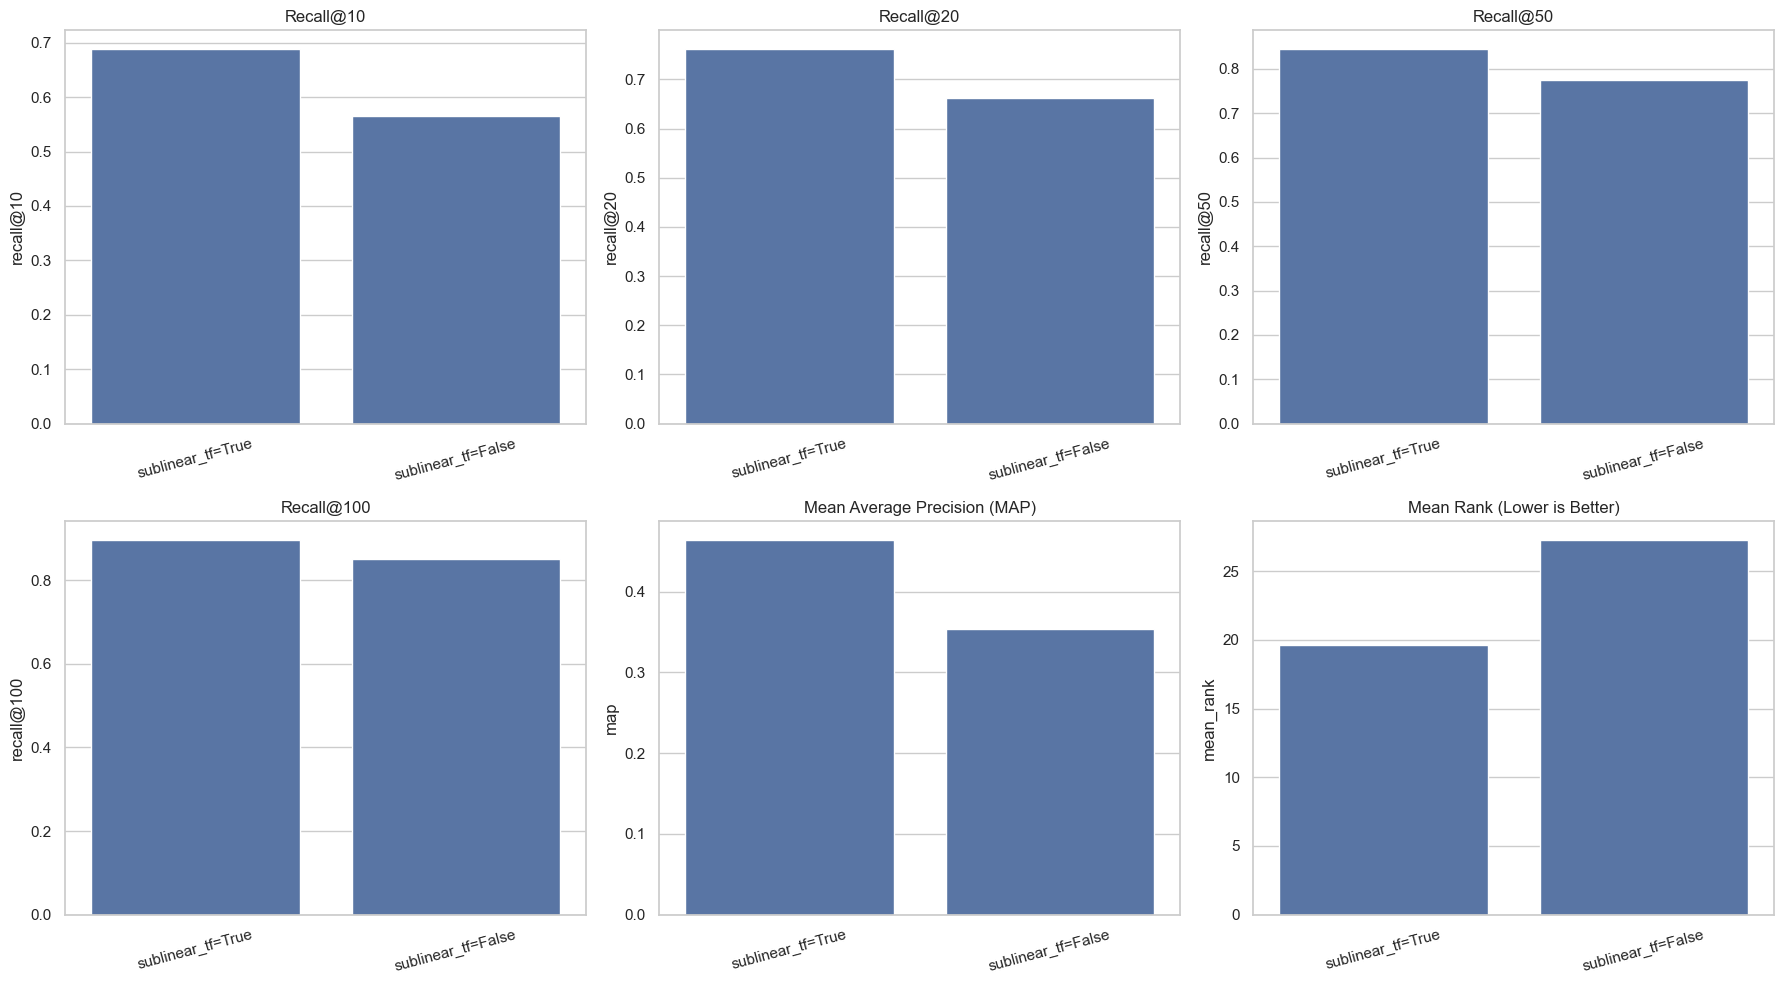

In [43]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Set visual style
sns.set(style="whitegrid")

# Plot all metrics in subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Recall@10, 20, 50, 100
sns.barplot(data=df_results, x='label', y='recall@10', ax=axes[0, 0])
axes[0, 0].set_title('Recall@10')

sns.barplot(data=df_results, x='label', y='recall@20', ax=axes[0, 1])
axes[0, 1].set_title('Recall@20')

sns.barplot(data=df_results, x='label', y='recall@50', ax=axes[0, 2])
axes[0, 2].set_title('Recall@50')

sns.barplot(data=df_results, x='label', y='recall@100', ax=axes[1, 0])
axes[1, 0].set_title('Recall@100')

# MAP
sns.barplot(data=df_results, x='label', y='map', ax=axes[1, 1])
axes[1, 1].set_title('Mean Average Precision (MAP)')

# Mean Rank (Lower is better)
sns.barplot(data=df_results, x='label', y='mean_rank', ax=axes[1, 2])
axes[1, 2].set_title('Mean Rank (Lower is Better)')

# Adjust layout
for ax in axes.flat:
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 2.6.3 Tune n-gram
- Unigram is better

In [44]:
settings = [(1, 1), (1, 2)]
results = []

for ngram in settings:
    label = f"ngram_range={ngram}"
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=30000,
        sublinear_tf=True,
        ngram_range=ngram
    )
    results.append(evaluate(claimsdesc_citing_train, claimsdesc_nonciting, vectorizer, mapping_dict, label))

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 30000

Results for ngram_range=(1, 1)
Recall@10: 0.6883
Recall@20: 0.7618
Recall@50: 0.8447
Recall@100: 0.8963
Mean Ranking: 19.6564
MAP: 0.4637
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 30000

Results for ngram_range=(1, 2)
Recall@10: 0.6391
Recall@20: 0.7205
Recall@50: 0.8171
Recall@100: 0.8721
Mean Ranking: 22.7855
MAP: 0.4277


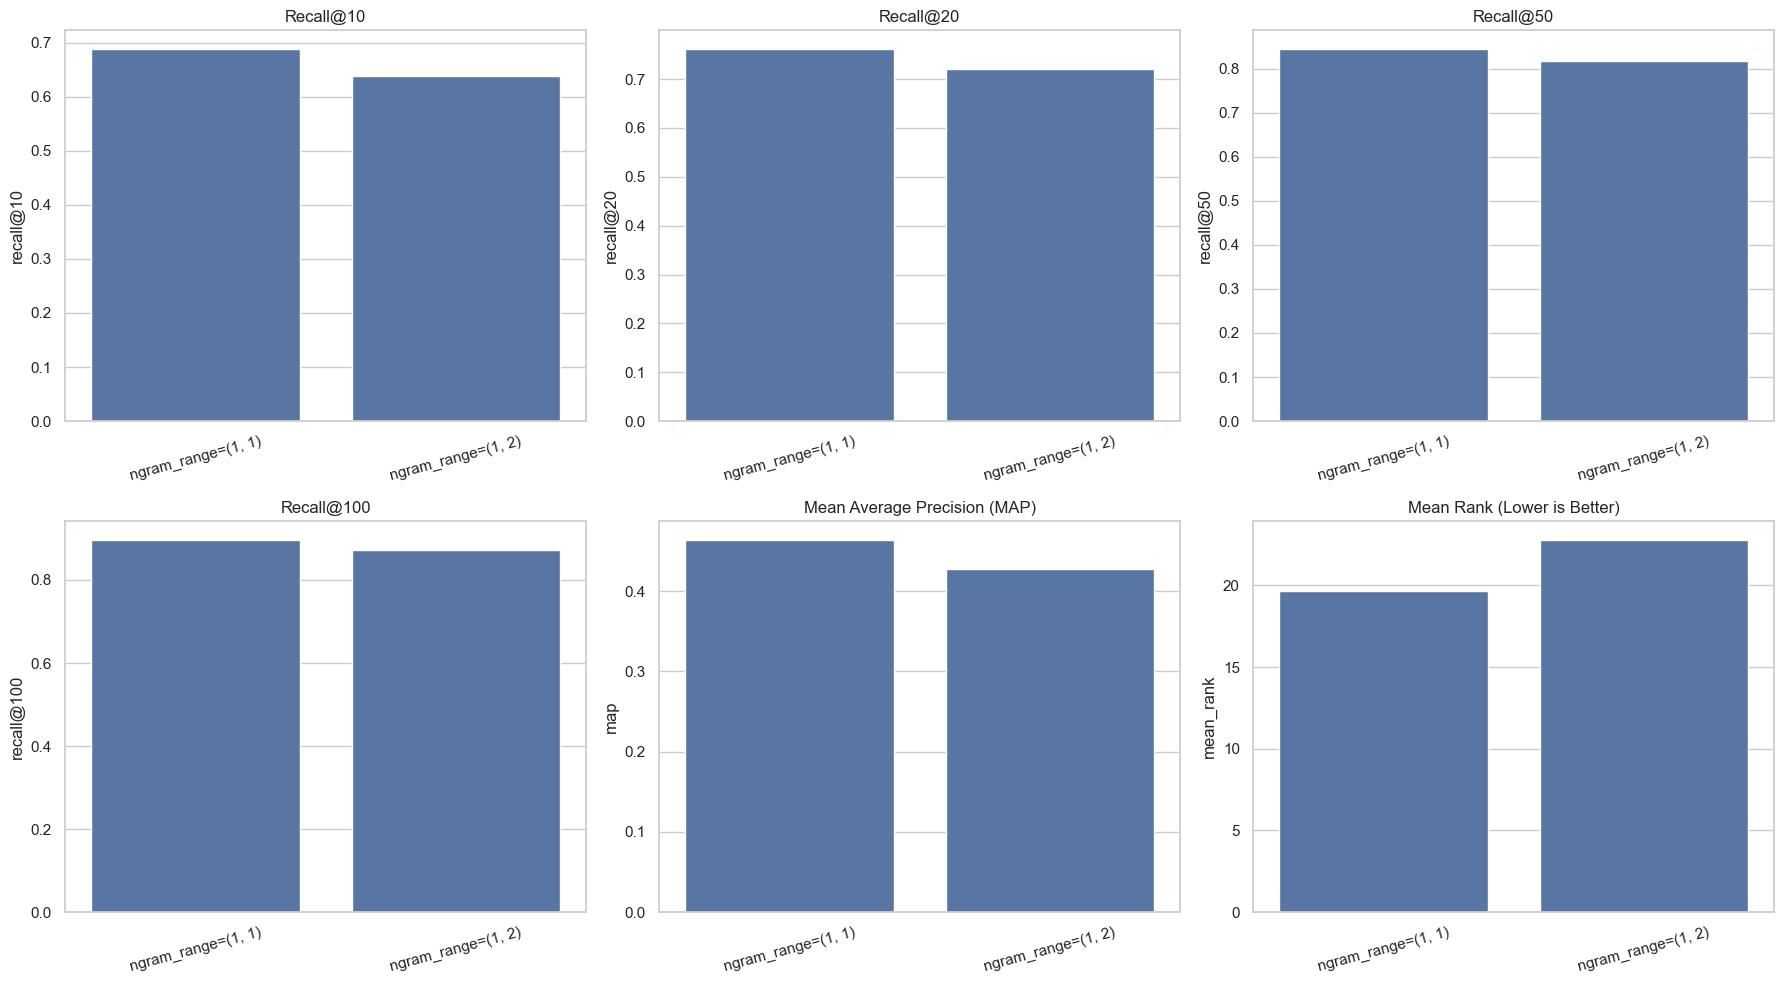

In [45]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Set visual style
sns.set(style="whitegrid")

# Plot all metrics in subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Recall@10, 20, 50, 100
sns.barplot(data=df_results, x='label', y='recall@10', ax=axes[0, 0])
axes[0, 0].set_title('Recall@10')

sns.barplot(data=df_results, x='label', y='recall@20', ax=axes[0, 1])
axes[0, 1].set_title('Recall@20')

sns.barplot(data=df_results, x='label', y='recall@50', ax=axes[0, 2])
axes[0, 2].set_title('Recall@50')

sns.barplot(data=df_results, x='label', y='recall@100', ax=axes[1, 0])
axes[1, 0].set_title('Recall@100')

# MAP
sns.barplot(data=df_results, x='label', y='map', ax=axes[1, 1])
axes[1, 1].set_title('Mean Average Precision (MAP)')

# Mean Rank (Lower is better)
sns.barplot(data=df_results, x='label', y='mean_rank', ax=axes[1, 2])
axes[1, 2].set_title('Mean Rank (Lower is Better)')

# Adjust layout
for ax in axes.flat:
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 2.6.4 Tune min_df and max_df
- We stick with default

In [46]:
param_pairs = [
    ("default", 1, 1.0),             # Keep all terms
    ("moderate-moderate", 0.01, 0.7),
    ("high-moderate", 0.05, 0.7),    # Aggressively drop rare terms
    ("moderate-high", 0.01, 0.9),    # Keep rare, trim frequent
    ("high-high", 0.05, 0.3),        # Aggressive on both ends
]
for param_pair in param_pairs:
    label = f"min_df={param_pair[1]}, max_df={param_pair[2]}"
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=30000,
        sublinear_tf=True,
        ngram_range=(1, 1),
        min_df=param_pair[1],
        max_df=param_pair[2]
    )
    results.append(evaluate(claimsdesc_citing_train, claimsdesc_nonciting, vectorizer, mapping_dict, label))

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 30000

Results for min_df=1, max_df=1.0
Recall@10: 0.6883
Recall@20: 0.7618
Recall@50: 0.8447
Recall@100: 0.8963
Mean Ranking: 19.6564
MAP: 0.4637
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 9942

Results for min_df=0.01, max_df=0.7
Recall@10: 0.6353
Recall@20: 0.7176
Recall@50: 0.8118
Recall@100: 0.8721
Mean Ranking: 23.1368
MAP: 0.4256
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 3207

Results for min_df=0.05, max_df=0.7
Recall@10: 0.5256
Recall@20: 0.6068
Recall@50: 0.7046
Recall@100: 0.7787
Mean Ranking: 33.4336
MAP: 0.3485
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 9982

Results for min_df=0.01, max_df=0.9
Recall@10: 0.6335
Recall@20: 0.7167
Recall@50: 0.8099
Recall@100: 0.8709
Mean Ranking: 23.2521
MAP: 0.4245
Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 2810

Results for min_df=0.05, max_df=0.3
Recall@10: 0.5446
Recall@20: 0.629
Recall@50: 0.7266
Recall@100: 0.797
Mean Ranking: 31.3955
MAP: 0.3522


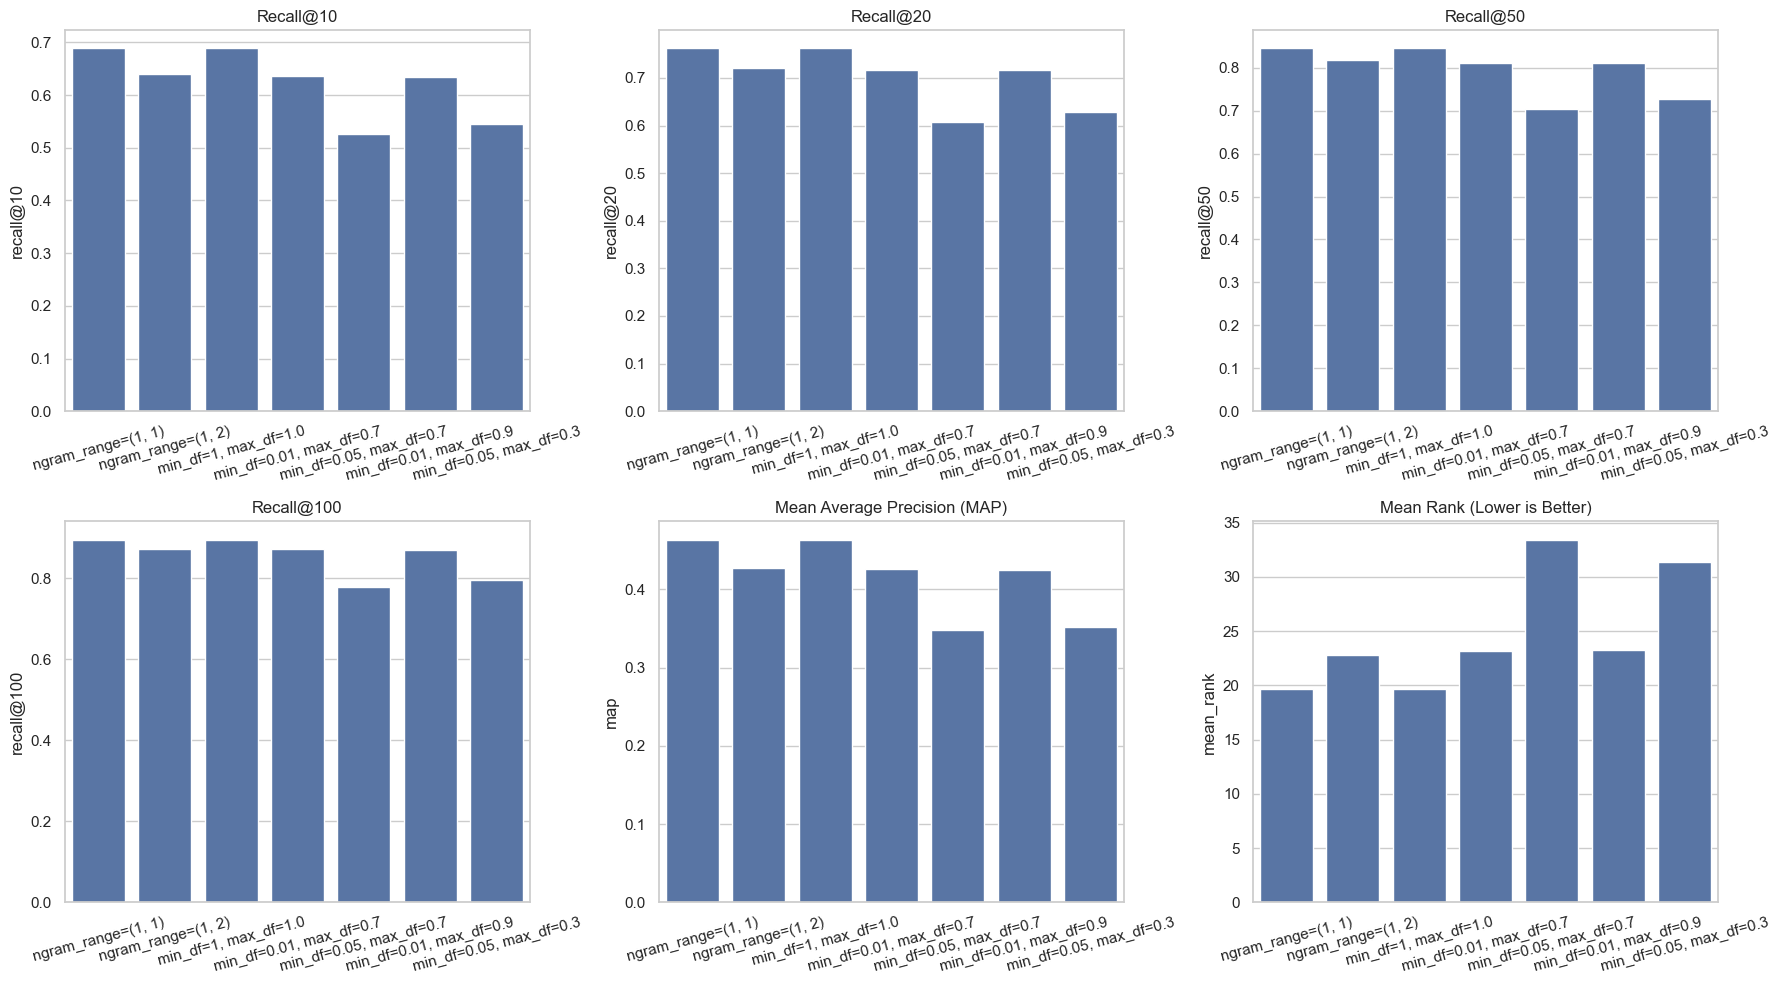

In [47]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Set visual style
sns.set(style="whitegrid")

# Plot all metrics in subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Recall@10, 20, 50, 100
sns.barplot(data=df_results, x='label', y='recall@10', ax=axes[0, 0])
axes[0, 0].set_title('Recall@10')

sns.barplot(data=df_results, x='label', y='recall@20', ax=axes[0, 1])
axes[0, 1].set_title('Recall@20')

sns.barplot(data=df_results, x='label', y='recall@50', ax=axes[0, 2])
axes[0, 2].set_title('Recall@50')

sns.barplot(data=df_results, x='label', y='recall@100', ax=axes[1, 0])
axes[1, 0].set_title('Recall@100')

# MAP
sns.barplot(data=df_results, x='label', y='map', ax=axes[1, 1])
axes[1, 1].set_title('Mean Average Precision (MAP)')

# Mean Rank (Lower is better)
sns.barplot(data=df_results, x='label', y='mean_rank', ax=axes[1, 2])
axes[1, 2].set_title('Mean Rank (Lower is Better)')

# Adjust layout
for ax in axes.flat:
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### The best baseline TF-IDF setting I use is 

TfidfVectorizer(
        stop_words='english',
        max_features=30000,
        sublinear_tf=True,
        ngram_range=(1, 1)
)

# 3.0 BM-25

## 3.1 Initialize BM25 Class

In [48]:
class BM25Score:
    """BM25 scoring algorithm implementation for document ranking."""

    def __init__(self, vectorized_docs, k1=1.5, b=0.75):
        """
        Initialize the BM25Score object.

        Parameters:
        - vectorized_docs (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized documents.
        - k1 (float, optional): Tuning parameter that controls term frequency normalization. Default is 1.5.
        - b (float, optional): Tuning parameter that controls the impact of document length normalization. Default is 0.75.
        """
        self.k1 = k1
        self.b = b
        self.vectorized_docs = vectorized_docs

    def fit(self, vectorized_queries=None, query_ids=None, args=None):
        """
        Fit the BM25 model to the provided vectorized documents.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix, optional): Sparse matrix of word counts representing vectorized queries. Default is None.
        - query_ids (list, optional): List of query IDs. Default is None.
        - args (dict, optional): Additional arguments for grid search integration. Default is None.

        Returns:
        - self (BM25Score): Returns the instance of the BM25Score object after fitting.
        """
        self.n_d = self.vectorized_docs.sum(axis=1).reshape(-1, 1).A
        self.avgdl = np.mean(self.n_d)
        self.n_docs = self.vectorized_docs.shape[0]

        self.nq = np.sum(self.vectorized_docs > 0, axis=0).reshape(1, -1)
        self.idf = np.log(((self.n_docs - self.nq + 0.5) / (self.nq + 0.5)) + 1).A
        return self

    def predict(self, vectorized_queries):
        """
        Predict relevance scores for the given vectorized queries.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized queries.

        Returns:
        - scores (numpy.ndarray): Array of relevance scores for the queries.
        """
        idx_tokens = np.argwhere(vectorized_queries.sum(axis=0) > 0).reshape(-1)
        vectorized_queries = vectorized_queries[:, idx_tokens]
        vectorized_docs = self.vectorized_docs[:, idx_tokens].toarray()
        idf = self.idf[:, idx_tokens]

        scores = idf * (
            (vectorized_docs * (self.k1 + 1)) / \
            (
                vectorized_docs + \
                self.k1 * (1 - self.b + self.b * (self.n_d / self.avgdl))
            )
        )

        return (vectorized_queries > 0).astype(np.int8) @ scores.T

def create_bm25_matrix(citing_dataset, nonciting_dataset, vectorizer=CountVectorizer()):
    """
    Creates BM25 similarity scores for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (CountVectorizer, optional): CountVectorizer object for vectorizing text data.
                                            Defaults to CountVectorizer().

    Returns:
    array: Similarity scores matrix between citing and non-citing patents.
    """
    all_text_citing = [patent['text'] for patent in citing_dataset]
    all_text_nonciting = [patent['text'] for patent in nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    vectorizer.fit(all_text_citing + all_text_nonciting)
    count_matrix_citing = vectorizer.transform(all_text_citing)
    count_matrix_nonciting = vectorizer.transform(all_text_nonciting)

    # Using BM25 scoring
    print("Computing BM25 scores...")
    bm25 = BM25Score(count_matrix_nonciting)
    bm25.fit()
    bm25_scores = bm25.predict(count_matrix_citing)

    return bm25_scores

## 3.2 'Title' BM25

In [49]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_train, title_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (6831, 16837)


In [50]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_bm25, 4))
print("Recall at 20:", round(recall_at_20_titles_bm25, 4))
print("Recall at 50:", round(recall_at_50_titles_bm25, 4))
print("Recall at 100:", round(recall_at_100_titles_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2706
Recall at 20: 0.3316
Recall at 50: 0.4102
Recall at 100: 0.4719
Mean ranking: 61.651
Mean average precision: 0.166
Number of patents measured: 6831
Number of patents not in the citation: 0


## 3.3 'Claims1' BM25

In [51]:
print(f"Number of citing: {len(claim1_citing)}")
print(f"Number of nonciting: {len(claim1_nonciting)}")
print(f"Sum: {len(claim1_citing) + len(claim1_nonciting)}")

Number of citing: 6831
Number of nonciting: 16834
Sum: 23665


In [52]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(claim1_citing, claim1_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (6831, 16834)


In [53]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.4077
Recall at 20: 0.4774
Recall at 50: 0.5743
Recall at 100: 0.6445
Mean ranking: 46.0553
Mean average precision: 0.2609
Number of patents measured: 6831
Number of patents not in the citation: 0


## 3.4 "Title, Abstract, and Claims" BM25

In [54]:
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

bm25_scores = create_bm25_matrix(
    citing_dataset=tac_citing_train,
    nonciting_dataset=tac_nonciting,
    vectorizer = count_vectorizer
)

Vectorizing descriptions...
Computing BM25 scores...


In [55]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(tac_citing_train, tac_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.4834
Recall at 20: 0.5653
Recall at 50: 0.6765
Recall at 100: 0.7571
Mean ranking: 36.4627
Mean average precision: 0.3036
Number of patents measured: 6831
Number of patents not in the citation: 0


## 3.5 "Claims and Descriptions" BM25

In [56]:
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

bm25_scores = create_bm25_matrix(
    citing_dataset=claimsdesc_citing_train,
    nonciting_dataset=claimsdesc_nonciting,
    vectorizer = count_vectorizer
)

Vectorizing descriptions...
Computing BM25 scores...


In [57]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claimsdesc_citing_train, claimsdesc_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2446
Recall at 20: 0.2939
Recall at 50: 0.3682
Recall at 100: 0.4492
Mean ranking: 65.1184
Mean average precision: 0.1513
Number of patents measured: 6831
Number of patents not in the citation: 0


## 3.6 "Fulltext" BM25

In [58]:
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

bm25_scores = create_bm25_matrix(
    citing_dataset=full_text_citing,
    nonciting_dataset=full_text_nonciting,
    vectorizer = count_vectorizer
)

Vectorizing descriptions...
Computing BM25 scores...


In [59]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(full_text_citing, full_text_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2443
Recall at 20: 0.2942
Recall at 50: 0.3681
Recall at 100: 0.4495
Mean ranking: 65.11
Mean average precision: 0.1513
Number of patents measured: 6831
Number of patents not in the citation: 0


## Conclusion for Sparse Embedding
- While intuitively, adding more textual context seems beneficial, we observe that for BM25, it leads to term dilution and poor keyword discriminability
- TF-IDF significantly outperforms BM25 with less memory. Therefore, we adopted TF-IDF as our primary sparse baseline for its superior performance and tunability

# 4.0 Get Test Predictions for CodaBench (Baseline TF-IDF)

Baseline TF-IDF result on test:
- MAP: 0.473
- Recall@100: 0.904

In [60]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=30000, sublinear_tf=True)
tfidf_citing, tfidf_cited = create_tfidf_matrix(claimsdesc_citing_test, claimsdesc_nonciting, tfidf_vectorizer)

cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)

Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 30000


In [61]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claimsdesc_citing_test, claimsdesc_nonciting, cosine_similarities, k=k)

with open('prediction1.json', 'w') as f:
    json.dump(top_k_rank, f)

In [62]:
# Also save it for later fusion
output_file = "results/tfidf_claims+desc_test_retrieved.json"
with open(output_file, "w") as f:
    json.dump(top_k_rank, f)

# 5.0 Dense Retrival

In [63]:
import os
import json
import numpy as np
import torch
from tqdm import tqdm
from pathlib import Path

In [64]:
# Model settings
MODEL_NAME = "all-MiniLM-L6-v2"  # Choose from: "all-MiniLM-L6-v2" or "PatentSBERTa"
CONTENT_TYPE = "TA"              # Choose from: "TA", "claims", or "TAC"
POOLING = "mean"                 # The pooling strategy used in create_embeddings.py
QUERY_SET = "test"              # Choose from: "train" or "test"
SAVE_RESULTS = True

# Retrieval settings
TOP_N = 100  # Number of documents to retrieve for each query

In [65]:
# Colab paths
BASE_DIR = "./"
DOC_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_docs")
TRAIN_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_train")
TEST_EMBEDDING_DIR = os.path.join(BASE_DIR, "embeddings_precalculated_test")
OUTPUT_DIR = os.path.join(BASE_DIR, "results")
CITATION_FILE = os.path.join(BASE_DIR, "Citation_JSONs/Citation_Train.json")

In [66]:
# Embedding files
DOC_EMBEDDING_FILE = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.npy")
DOC_APP_IDS_FILE = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.json")

# Select query embedding directory based on QUERY_SET
QUERY_EMBEDDING_DIR = TRAIN_EMBEDDING_DIR if QUERY_SET == "train" else TEST_EMBEDDING_DIR
QUERY_EMBEDDING_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.npy")
QUERY_APP_IDS_FILE = os.path.join(QUERY_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{CONTENT_TYPE}.json")

# Evaluation settings
K_VALUE = 10  # K value for Recall@K evaluation
METRICS_TYPE = "all"  # Metrics to calculate: "recall_at_k", "mean_ranking", "mean_inv_ranking", or "all"

## Utilities

In [67]:
# === CELL: Utility functions for cosine similarity ===
def cos_sim(a, b):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j] = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

def pytorch_cos_sim(a, b):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j] = cos_sim(a[i], b[j])
    """
    return cos_sim(a, b)

# === CELL: Utility functions for evaluation metrics ===
def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set) if len(true_set) > 0 else 0)

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k) if recalls_at_k else 0

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks) if ranks else 0
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks) if mean_ranks else 0

    return mean_of_mean_ranks

def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks) if ranks else 0
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks) if mean_ranks else 0

    return mean_of_mean_ranks

# === CELL: Citation utility functions ===
def citation_to_citing_to_cited_dict(citations):
    """
    Put a citation mapping in a dict format
    """
    # Initialize an empty dictionary to store the results
    citing_to_cited_dict = {}

    # Iterate over the items in the JSON list
    for citation in citations:
        # Check if the citing id already exists in the resulting dictionary
        if citation[0] in citing_to_cited_dict:
            # If the citing id exists, append the cited id to the existing list
            citing_to_cited_dict[citation[0]].append(citation[2])
        else:
            # If the citing id doesn't exist, create a new list with the cited id for that citing id
            citing_to_cited_dict[citation[0]] = [citation[2]]

    return citing_to_cited_dict

def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            print(citing_id, "not in citation mapping")
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping

# === CELL: Function to load embeddings ===
def load_embeddings_and_ids(embedding_file, app_ids_file):
    """
    Load the embeddings and application IDs from saved files
    """
    print(f"Loading embeddings from {embedding_file}")
    embeddings = torch.from_numpy(np.load(embedding_file))

    print(f"Loading app_ids from {app_ids_file}")
    with open(app_ids_file, 'r') as f:
        app_ids = json.load(f)

    print(f"Loaded {len(embeddings)} embeddings and {len(app_ids)} app_ids")
    return embeddings, app_ids

## Load document and query embeddings

In [68]:
# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Load document embeddings and app_ids
doc_embeddings, doc_app_ids = load_embeddings_and_ids(DOC_EMBEDDING_FILE, DOC_APP_IDS_FILE)

# Load query embeddings and app_ids
query_embeddings, query_app_ids = load_embeddings_and_ids(QUERY_EMBEDDING_FILE, QUERY_APP_IDS_FILE)

# Move tensors to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
doc_embeddings = doc_embeddings.to(device)
query_embeddings = query_embeddings.to(device)

print(f"Running retrieval with {len(query_embeddings)} queries against {len(doc_embeddings)} documents")

Loading embeddings from ./embeddings_precalculated_docs/embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_test/embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_test/app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 1000 embeddings and 1000 app_ids
Running retrieval with 1000 queries against 16837 documents


In [69]:
def retrieve_by_app_id(target_app_id, query_app_ids, query_embeddings, doc_embeddings, doc_app_ids, top_n=10):
    """
    Retrieve top N documents for a single query by its app_id

    Parameters:
    - target_app_id: The application ID of the query to search for
    - query_app_ids: List of all query application IDs
    - query_embeddings: Embeddings for all queries
    - doc_embeddings: Embeddings for all documents in the corpus
    - doc_app_ids: Application IDs for all documents
    - top_n: Number of results to return

    Returns:
    - List of top N document app_ids similar to the query
    """
    try:
        # Find the index of the target app_id in query_app_ids
        query_index = query_app_ids.index(target_app_id)

        # Get the corresponding embedding
        query_embedding = query_embeddings[query_index].unsqueeze(0)

        # Compute cosine similarity
        cos_scores = pytorch_cos_sim(query_embedding, doc_embeddings)[0].cpu()

        # Sort results and get top N
        top_n_index = torch.argsort(cos_scores, descending=True)[:top_n].numpy()

        # Get application IDs of top N documents
        top_n_app_ids = [doc_app_ids[i] for i in top_n_index]
        top_n_scores = [cos_scores[i].item() for i in top_n_index]

        return top_n_app_ids, top_n_scores

    except ValueError:
        print(f"Error: Application ID '{target_app_id}' not found in query_app_ids")
        return [], []

# Example usage
target_app_id = query_app_ids[0]  # Replace with the specific app_id you want to query
retrieved_app_ids, similarity_scores = retrieve_by_app_id(
    target_app_id,
    query_app_ids,
    query_embeddings,
    doc_embeddings,
    doc_app_ids,
    top_n=TOP_N
)

# Display results
print(f"Top {TOP_N} results for query {target_app_id}:")
for app_id, score in zip(retrieved_app_ids, similarity_scores):
    print(f"App ID: {app_id}, Similarity: {score:.4f}")

Top 100 results for query 3708804A1:
App ID: 2169237A2, Similarity: 0.6300
App ID: 3543539A1, Similarity: 0.6215
App ID: 3067624A1, Similarity: 0.6027
App ID: 3444468A1, Similarity: 0.5983
App ID: 3034804A1, Similarity: 0.5953
App ID: 3290716A1, Similarity: 0.5943
App ID: 2224100A2, Similarity: 0.5932
App ID: 3216987A1, Similarity: 0.5848
App ID: 2540994A1, Similarity: 0.5845
App ID: 3187692A1, Similarity: 0.5804
App ID: 2631434A2, Similarity: 0.5801
App ID: 3269930A1, Similarity: 0.5798
App ID: 3184750A1, Similarity: 0.5789
App ID: 3034794A1, Similarity: 0.5770
App ID: 2402616A1, Similarity: 0.5752
App ID: 1788688B1, Similarity: 0.5749
App ID: 2792850A1, Similarity: 0.5731
App ID: 3382280A1, Similarity: 0.5729
App ID: 3098382A1, Similarity: 0.5721
App ID: 2746536A1, Similarity: 0.5719
App ID: 3441618A1, Similarity: 0.5714
App ID: 3163025A1, Similarity: 0.5709
App ID: 2716914A1, Similarity: 0.5660
App ID: 3321474A1, Similarity: 0.5659
App ID: 2905477A1, Similarity: 0.5653
App ID: 28515

## Perform retrieval for each query

In [70]:
results = {}
for i, (query_embedding, query_id) in enumerate(tqdm(zip(query_embeddings, query_app_ids), total=len(query_embeddings))):
    # Compute cosine similarity
    query_embedding = query_embedding.unsqueeze(0)
    cos_scores = pytorch_cos_sim(query_embedding, doc_embeddings)[0].cpu()

    # Sort results and get top N
    top_n_index = torch.argsort(cos_scores, descending=True)[:TOP_N].numpy()

    # Get application IDs of top N documents
    top_n_app_ids = [doc_app_ids[i] for i in top_n_index]
    results[query_id] = top_n_app_ids

100%|██████████| 1000/1000 [00:04<00:00, 220.23it/s]


## Save results (if applicable)

In [71]:
if QUERY_SET == "train":
    output_file = f"{OUTPUT_DIR}/{MODEL_NAME}_{CONTENT_TYPE}_{QUERY_SET}_retrieved.json"
else:
    output_file = f"{OUTPUT_DIR}/prediction1.json"  # Standard filename for test predictions

if SAVE_RESULTS:
    with open(output_file, 'w') as f:
        json.dump(results, f)
    print(f"Saved retrieval results to {output_file}")
else:
    print(f"Results not saved (SAVE_RESULTS={SAVE_RESULTS})")

Saved retrieval results to ./results/prediction1.json


## Evaluation (for training set only)

In [72]:
if QUERY_SET == "train":
    print("Evaluating train set results...")

    # Load citation mapping
    print(f"Loading citation data from {CITATION_FILE}")
    with open(CITATION_FILE, 'r') as f:
        citations = json.load(f)

    # Convert citations to citing-to-cited dictionary
    citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

    # Get true and predicted labels
    true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
        citing_to_cited_dict, results
    )

    # Calculate metrics
    print("\nEvaluation Results:")
    print("-------------------")

    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=K_VALUE)
        print(f"Recall@{K_VALUE}: {recall_at_k:.4f}")

    if METRICS_TYPE in ['mean_ranking', 'all']:
        mean_rank = mean_ranking(true_labels, predicted_labels)
        print(f"Mean Ranking: {mean_rank:.4f}")

    if METRICS_TYPE in ['mean_inv_ranking', 'all']:
        mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
        print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

    print(f"\nNumber of patents measured: {len(predicted_labels)}")
    print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")
else:
    print("\nTest set retrieval completed. No evaluation performed.")
    if SAVE_RESULTS:
        print(f"Predictions saved to {OUTPUT_DIR}/prediction1.json")
    print("Note: For the test set, citation data is not available for evaluation.")


Test set retrieval completed. No evaluation performed.
Predictions saved to ./results/prediction1.json
Note: For the test set, citation data is not available for evaluation.


## 5.1 all-MiniLM-L6-v2

In [73]:
MODEL_NAME = "all-MiniLM-L6-v2"
POOLING = "mean"
QUERY_SET = "train"
TOP_N = 100
CONTENT_TYPES = ["TA", "claims", "TAC"]

In [74]:
for content_type in CONTENT_TYPES:
    print(f"\n=== Running retrieval for content type: {content_type} ===")

    # Define file paths
    doc_embed_file = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{content_type}.npy")
    doc_ids_file = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{content_type}.json")

    query_embed_file = os.path.join(TRAIN_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{content_type}.npy")
    query_ids_file = os.path.join(TRAIN_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{content_type}.json")

    # Load embeddings
    doc_embeddings, doc_app_ids = load_embeddings_and_ids(doc_embed_file, doc_ids_file)
    query_embeddings, query_app_ids = load_embeddings_and_ids(query_embed_file, query_ids_file)

    # Move to GPU
    doc_embeddings = doc_embeddings.to(device)
    query_embeddings = query_embeddings.to(device)

    # Perform retrieval
    results = {}
    for i, (query_embedding, query_id) in enumerate(tqdm(zip(query_embeddings, query_app_ids), total=len(query_embeddings))):
        query_embedding = query_embedding.unsqueeze(0)
        cos_scores = pytorch_cos_sim(query_embedding, doc_embeddings)[0].cpu()
        top_n_index = torch.argsort(cos_scores, descending=True)[:TOP_N].numpy()
        top_n_app_ids = [doc_app_ids[i] for i in top_n_index]
        results[query_id] = top_n_app_ids

    # Save results
    output_file = os.path.join(OUTPUT_DIR, f"{MODEL_NAME}_{content_type}_{QUERY_SET}_retrieved.json")
    with open(output_file, "w") as f:
        json.dump(results, f)

    print(f"Saved retrieval results to {output_file}")



=== Running retrieval for content type: TA ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_train/embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_train/app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids


100%|██████████| 6831/6831 [00:28<00:00, 236.21it/s]


Saved retrieval results to ./results/all-MiniLM-L6-v2_TA_train_retrieved.json

=== Running retrieval for content type: claims ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids
Loading embeddings from ./embeddings_precalculated_train/embeddings_all-MiniLM-L6-v2_mean_claims.npy
Loading app_ids from ./embeddings_precalculated_train/app_ids_all-MiniLM-L6-v2_mean_claims.json
Loaded 6831 embeddings and 6831 app_ids


100%|██████████| 6831/6831 [00:25<00:00, 268.51it/s]


Saved retrieval results to ./results/all-MiniLM-L6-v2_claims_train_retrieved.json

=== Running retrieval for content type: TAC ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_all-MiniLM-L6-v2_mean_TAC.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_all-MiniLM-L6-v2_mean_TAC.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_train/embeddings_all-MiniLM-L6-v2_mean_TAC.npy
Loading app_ids from ./embeddings_precalculated_train/app_ids_all-MiniLM-L6-v2_mean_TAC.json
Loaded 6831 embeddings and 6831 app_ids


100%|██████████| 6831/6831 [00:24<00:00, 283.08it/s]


Saved retrieval results to ./results/all-MiniLM-L6-v2_TAC_train_retrieved.json


In [75]:
with open("results/all-MiniLM-L6-v2_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

with open("results/all-MiniLM-L6-v2_claims_train_retrieved.json", "r") as f:
    results_claims = json.load(f)

with open("results/all-MiniLM-L6-v2_TAC_train_retrieved.json", "r") as f:
    results_tac = json.load(f)

In [76]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, results_ta
)

# Evaluate metrics
print("\nEvaluation Results for all-MiniLM-L6-v2 - TA:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for all-MiniLM-L6-v2 - TA:
----------------------------------
Recall@10: 0.5459
Recall@20: 0.6348
Recall@50: 0.7516
Recall@100: 0.8216
Mean Ranking: 29.5899
Mean Inverse Ranking: 0.3453

Number of patents measured: 6831
Number of patents not in citation mapping: 0


In [77]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, results_claims
)

# Evaluate metrics
print("\nEvaluation Results for all-MiniLM-L6-v2 - Claims:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for all-MiniLM-L6-v2 - Claims:
----------------------------------
Recall@10: 0.4951
Recall@20: 0.5885
Recall@50: 0.7034
Recall@100: 0.7795
Mean Ranking: 34.2232
Mean Inverse Ranking: 0.3102

Number of patents measured: 6831
Number of patents not in citation mapping: 0


In [78]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, results_tac
)

# Evaluate metrics
print("\nEvaluation Results for all-MiniLM-L6-v2 - TAC:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for all-MiniLM-L6-v2 - TAC:
----------------------------------
Recall@10: 0.5560
Recall@20: 0.6395
Recall@50: 0.7456
Recall@100: 0.8170
Mean Ranking: 29.8568
Mean Inverse Ranking: 0.3432

Number of patents measured: 6831
Number of patents not in citation mapping: 0


## 5.2 PatentSBERTa

In [79]:
MODEL_NAME = "PatentSBERTa"
POOLING = "mean"
QUERY_SET = "train"
TOP_N = 100
CONTENT_TYPES = ["TA", "claims", "TAC"]

In [80]:
for content_type in CONTENT_TYPES:
    print(f"\n=== Running retrieval for content type: {content_type} ===")

    # Define file paths
    doc_embed_file = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{content_type}.npy")
    doc_ids_file = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{content_type}.json")

    query_embed_file = os.path.join(TRAIN_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{content_type}.npy")
    query_ids_file = os.path.join(TRAIN_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{content_type}.json")

    # Load embeddings
    doc_embeddings, doc_app_ids = load_embeddings_and_ids(doc_embed_file, doc_ids_file)
    query_embeddings, query_app_ids = load_embeddings_and_ids(query_embed_file, query_ids_file)

    # Move to GPU
    doc_embeddings = doc_embeddings.to(device)
    query_embeddings = query_embeddings.to(device)

    # Perform retrieval
    results = {}
    for i, (query_embedding, query_id) in enumerate(tqdm(zip(query_embeddings, query_app_ids), total=len(query_embeddings))):
        query_embedding = query_embedding.unsqueeze(0)
        cos_scores = pytorch_cos_sim(query_embedding, doc_embeddings)[0].cpu()
        top_n_index = torch.argsort(cos_scores, descending=True)[:TOP_N].numpy()
        top_n_app_ids = [doc_app_ids[i] for i in top_n_index]
        results[query_id] = top_n_app_ids

    # Save results
    output_file = os.path.join(OUTPUT_DIR, f"{MODEL_NAME}_{content_type}_{QUERY_SET}_retrieved.json")
    with open(output_file, "w") as f:
        json.dump(results, f)

    print(f"Saved retrieval results to {output_file}")


=== Running retrieval for content type: TA ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_PatentSBERTa_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_PatentSBERTa_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_train/embeddings_PatentSBERTa_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_train/app_ids_PatentSBERTa_mean_TA.json
Loaded 6831 embeddings and 6831 app_ids


100%|██████████| 6831/6831 [00:39<00:00, 173.27it/s]


Saved retrieval results to ./results/PatentSBERTa_TA_train_retrieved.json

=== Running retrieval for content type: claims ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_PatentSBERTa_mean_claims.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_PatentSBERTa_mean_claims.json
Loaded 16834 embeddings and 16834 app_ids
Loading embeddings from ./embeddings_precalculated_train/embeddings_PatentSBERTa_mean_claims.npy
Loading app_ids from ./embeddings_precalculated_train/app_ids_PatentSBERTa_mean_claims.json
Loaded 6831 embeddings and 6831 app_ids


100%|██████████| 6831/6831 [00:40<00:00, 168.15it/s]


Saved retrieval results to ./results/PatentSBERTa_claims_train_retrieved.json

=== Running retrieval for content type: TAC ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_PatentSBERTa_mean_TAC.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_PatentSBERTa_mean_TAC.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_train/embeddings_PatentSBERTa_mean_TAC.npy
Loading app_ids from ./embeddings_precalculated_train/app_ids_PatentSBERTa_mean_TAC.json
Loaded 6831 embeddings and 6831 app_ids


100%|██████████| 6831/6831 [00:40<00:00, 167.28it/s]


Saved retrieval results to ./results/PatentSBERTa_TAC_train_retrieved.json


In [81]:
with open("results/PatentSBERTa_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

with open("results/PatentSBERTa_claims_train_retrieved.json", "r") as f:
    results_claims = json.load(f)

with open("results/PatentSBERTa_TAC_train_retrieved.json", "r") as f:
    results_tac = json.load(f)

In [82]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, results_ta
)

# Evaluate metrics
print("\nEvaluation Results for PatentSBERTa - TA:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for PatentSBERTa - TA:
----------------------------------
Recall@10: 0.5249
Recall@20: 0.6106
Recall@50: 0.7227
Recall@100: 0.7965
Mean Ranking: 32.0866
Mean Inverse Ranking: 0.3289

Number of patents measured: 6831
Number of patents not in citation mapping: 0


In [83]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, results_claims
)

# Evaluate metrics
print("\nEvaluation Results for PatentSBERTa - Claims:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for PatentSBERTa - Claims:
----------------------------------
Recall@10: 0.4568
Recall@20: 0.5412
Recall@50: 0.6542
Recall@100: 0.7323
Mean Ranking: 38.8181
Mean Inverse Ranking: 0.2833

Number of patents measured: 6831
Number of patents not in citation mapping: 0


In [84]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, results_tac
)

# Evaluate metrics
print("\nEvaluation Results for PatentSBERTa - TAC:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for PatentSBERTa - TAC:
----------------------------------
Recall@10: 0.5297
Recall@20: 0.6187
Recall@50: 0.7262
Recall@100: 0.8021
Mean Ranking: 31.6805
Mean Inverse Ranking: 0.3293

Number of patents measured: 6831
Number of patents not in citation mapping: 0


## 5.2 Reciprocal Rank Fusion (RRF)

In [85]:
from collections import defaultdict

def reciprocal_rank_fusion(rankings_list, k=60, top_n=100):
    """
    Perform Reciprocal Rank Fusion (RRF) on multiple ranked lists for each query.

    Parameters:
    - rankings_list: List of dicts. Each dict maps query_id -> list of ranked doc_ids (one per retrieval system).
    - k: Constant to dampen the impact of high ranks (typically 60).
    - top_n: Number of final results to return per query.

    Returns:
    - fused_rankings: dict mapping query_id -> fused list of doc_ids ranked by RRF score.
    """
    fused_rankings = {}

    # Iterate over each query
    query_ids = rankings_list[0].keys()  # Assume all retrievals use same query_ids
    for query_id in query_ids:
        doc_scores = defaultdict(float)

        # Aggregate scores from each ranking list
        for ranking in rankings_list:
            ranked_docs = ranking.get(query_id, [])
            for rank, doc_id in enumerate(ranked_docs):
                doc_scores[doc_id] += 1 / (k + rank)

        # Sort by RRF score descending
        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        fused_rankings[query_id] = [doc_id for doc_id, _ in sorted_docs[:top_n]]

    return fused_rankings

### 5.2.1 PatentSBERTa TA with PatentSBERTa claims

In [86]:
with open("results/PatentSBERTa_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

with open("results/PatentSBERTa_claims_train_retrieved.json", "r") as f:
    results_claims = json.load(f)

fused_results = reciprocal_rank_fusion([results_ta, results_claims], k=60, top_n=TOP_N)

In [87]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate metrics
print("\nEvaluation Results for Fused RRF:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for Fused RRF:
----------------------------------
Recall@10: 0.5571
Recall@20: 0.6562
Recall@50: 0.7700
Recall@100: 0.8317
Mean Ranking: 28.1430
Mean Inverse Ranking: 0.3459

Number of patents measured: 6831
Number of patents not in citation mapping: 0


### 5.2.2 PatentSBERTa TA with PatentSBERTa TAC

In [88]:
with open("results/PatentSBERTa_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

with open("results/PatentSBERTa_TAC_train_retrieved.json", "r") as f:
    results_tac = json.load(f)

fused_results = reciprocal_rank_fusion([results_ta, results_tac], k=60, top_n=TOP_N)

In [89]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate metrics
print("\nEvaluation Results for Fused RRF:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for Fused RRF:
----------------------------------
Recall@10: 0.5694
Recall@20: 0.6574
Recall@50: 0.7668
Recall@100: 0.8318
Mean Ranking: 28.0101
Mean Inverse Ranking: 0.3564

Number of patents measured: 6831
Number of patents not in citation mapping: 0


### 5.2.3 all-MiniLM TA with all-MiniLM Claims

In [90]:
with open("results/all-MiniLM-L6-v2_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

with open("results/all-MiniLM-L6-v2_claims_train_retrieved.json", "r") as f:
    results_claims = json.load(f)

fused_results = reciprocal_rank_fusion([results_ta, results_claims], k=60, top_n=TOP_N)

In [91]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate metrics
print("\nEvaluation Results for Fused RRF:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for Fused RRF:
----------------------------------
Recall@10: 0.5822
Recall@20: 0.6780
Recall@50: 0.7911
Recall@100: 0.8544
Mean Ranking: 25.8805
Mean Inverse Ranking: 0.3602

Number of patents measured: 6831
Number of patents not in citation mapping: 0


### 5.2.3 all-MiniLM TA with all-MiniLM TAC

In [92]:
with open("results/all-MiniLM-L6-v2_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

with open("results/all-MiniLM-L6-v2_TAC_train_retrieved.json", "r") as f:
    results_tac = json.load(f)

fused_results = reciprocal_rank_fusion([results_ta, results_tac], k=60, top_n=TOP_N)

In [93]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate metrics
print("\nEvaluation Results for Fused RRF:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for Fused RRF:
----------------------------------
Recall@10: 0.5916
Recall@20: 0.6811
Recall@50: 0.7831
Recall@100: 0.8488
Mean Ranking: 26.2079
Mean Inverse Ranking: 0.3695

Number of patents measured: 6831
Number of patents not in citation mapping: 0


### 5.2.4 all-MiniLM TAC with PatentSBERTa TA

In [94]:
with open("results/all-MiniLM-L6-v2_TAC_train_retrieved.json", "r") as f:
    results_tac = json.load(f)

with open("results/PatentSBERTa_TA_train_retrieved.json", "r") as f:
    results_ta = json.load(f)

fused_results = reciprocal_rank_fusion([results_tac, results_ta], k=60, top_n=TOP_N)

In [95]:
# Load citation mapping
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Prepare citation dict
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true and predicted labels
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate metrics
print("\nEvaluation Results for Fused RRF:")
print("----------------------------------")

# Evaluate Recall@K for multiple K values
for k in [10, 20, 50, 100]:
    if METRICS_TYPE in ['recall_at_k', 'all']:
        recall_at_k = mean_recall_at_k(true_labels, predicted_labels, k=k)
        print(f"Recall@{k}: {recall_at_k:.4f}")

if METRICS_TYPE in ['mean_ranking', 'all']:
    mean_rank = mean_ranking(true_labels, predicted_labels)
    print(f"Mean Ranking: {mean_rank:.4f}")

if METRICS_TYPE in ['mean_inv_ranking', 'all']:
    mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)
    print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")

print(f"\nNumber of patents measured: {len(predicted_labels)}")
print(f"Number of patents not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for Fused RRF:
----------------------------------
Recall@10: 0.6071
Recall@20: 0.6964
Recall@50: 0.7959
Recall@100: 0.8542
Mean Ranking: 25.0961
Mean Inverse Ranking: 0.3846

Number of patents measured: 6831
Number of patents not in citation mapping: 0


### 5.2.5 Sparse (TF-IDF) and all-MiniLM-L6-v2 TAC

In [96]:
# Load TF-IDF retrieval results (claims + desc)
with open("results/tfidf_claims+desc_train_retrieved.json", "r") as f:
    tfidf_results = json.load(f)

# Load dense retrieval results (PatentSBERTa TAC)
with open("results/all-MiniLM-L6-v2_TAC_train_retrieved.json", "r") as f:
    dense_results = json.load(f)

fused_results = reciprocal_rank_fusion([tfidf_results, dense_results], k=60, top_n=TOP_N)

In [97]:
# Load citation file
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Build citation dictionary
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true/predicted pairs
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate across multiple K values
print("\nEvaluation Results for TF-IDF + Dense (TAC) via RRF:")
print("--------------------------------------------------------")
for k in [10, 20, 50, 100]:
    recall = mean_recall_at_k(true_labels, predicted_labels, k=k)
    print(f"Recall@{k}: {recall:.4f}")

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)

print(f"\nMean Ranking: {mean_rank:.4f}")
print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")
print(f"\n# Measured: {len(predicted_labels)} | Not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for TF-IDF + Dense (TAC) via RRF:
--------------------------------------------------------
Recall@10: 0.6919
Recall@20: 0.7884
Recall@50: 0.8852
Recall@100: 0.9246

Mean Ranking: 16.7356
Mean Inverse Ranking: 0.4503

# Measured: 6831 | Not in citation mapping: 0


### 5.2.6 TF-IDF, all-MiniLM-L6-v2 TAC, and all-MiniLM-L6-v2 TA

In [98]:
with open("results/all-MiniLM-L6-v2_TA_train_retrieved.json", "r") as f:
    dense_ta = json.load(f)

fused_results = reciprocal_rank_fusion([tfidf_results, dense_results, dense_ta], k=60, top_n=TOP_N)

In [99]:
# Load citation file
with open("Citation_JSONs/Citation_Train.json", "r") as f:
    citations = json.load(f)

# Build citation dictionary
citing_to_cited_dict = citation_to_citing_to_cited_dict(citations)

# Get true/predicted pairs
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

# Evaluate across multiple K values
print("\nEvaluation Results for TF-IDF + TAC + TA via RRF:")
print("--------------------------------------------------------")
for k in [10, 20, 50, 100]:
    recall = mean_recall_at_k(true_labels, predicted_labels, k=k)
    print(f"Recall@{k}: {recall:.4f}")

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)

print(f"\nMean Ranking: {mean_rank:.4f}")
print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")
print(f"\n# Measured: {len(predicted_labels)} | Not in citation mapping: {not_in_citation_mapping}")


Evaluation Results for TF-IDF + TAC + TA via RRF:
--------------------------------------------------------
Recall@10: 0.6931
Recall@20: 0.7727
Recall@50: 0.8751
Recall@100: 0.9333

Mean Ranking: 17.1475
Mean Inverse Ranking: 0.4558

# Measured: 6831 | Not in citation mapping: 0


### 5.2.7 Weighted RRF: TF-IDF, all-MiniLM-L6-v2 TAC, and all-MiniLM-L6-v2 TA

In [100]:
def weighted_rrf(rankings_list, weights=None, k=60, top_n=100):
    from collections import defaultdict
    fused_rankings = {}
    query_ids = rankings_list[0].keys()
    weights = weights or [1.0] * len(rankings_list)

    for query_id in query_ids:
        doc_scores = defaultdict(float)
        for rank_idx, ranking in enumerate(rankings_list):
            ranked_docs = ranking.get(query_id, [])
            for rank, doc_id in enumerate(ranked_docs):
                doc_scores[doc_id] += weights[rank_idx] / (k + rank)

        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        fused_rankings[query_id] = [doc_id for doc_id, _ in sorted_docs[:top_n]]

    return fused_rankings


In [101]:
with open("results/tfidf_claims+desc_train_retrieved.json", "r") as f:
    tfidf_results = json.load(f)

with open("results/all-MiniLM-L6-v2_TAC_train_retrieved.json", "r") as f:
    tac_results = json.load(f)

with open("results/all-MiniLM-L6-v2_TA_train_retrieved.json", "r") as f:
    ta_results = json.load(f)

In [102]:
weights = [1.5, 1.0, 0.7]
fused_results = weighted_rrf([tfidf_results, tac_results, ta_results], weights=weights, k=60, top_n=TOP_N)

In [103]:
true_labels, predicted_labels, _ = get_true_and_predicted(
    citing_to_cited_dict, fused_results
)

print(f"\n🔍 Evaluation for weights TF-IDF={weights[0]}, TAC={weights[1]}, TA={weights[2]}")
for k in [10, 20, 50, 100]:
    recall = mean_recall_at_k(true_labels, predicted_labels, k=k)
    print(f"Recall@{k}: {recall:.4f}")

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_inv_rank = mean_inv_ranking(true_labels, predicted_labels)

print(f"\nMean Ranking: {mean_rank:.4f}")
print(f"Mean Inverse Ranking: {mean_inv_rank:.4f}")


🔍 Evaluation for weights TF-IDF=1.5, TAC=1.0, TA=0.7
Recall@10: 0.7165
Recall@20: 0.8064
Recall@50: 0.8976
Recall@100: 0.9335

Mean Ranking: 15.2720
Mean Inverse Ranking: 0.4689


# 6.0 Get Final Prediction for Task 1

Result using this on Codabench:
- MAP: 0.499
- Recall@100: 0.94

In [104]:
MODEL_NAME = "all-MiniLM-L6-v2"
POOLING = "mean"
QUERY_SET = "test"  # or "train"
TOP_N = 100
CONTENT_TYPES = ["TA", "TAC"]  # we'll loop through both

for content_type in CONTENT_TYPES:
    print(f"\n=== Running retrieval for content type: {content_type} ===")

    # Define file paths
    doc_embed_file = os.path.join(DOC_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{content_type}.npy")
    doc_ids_file = os.path.join(DOC_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{content_type}.json")

    query_embed_file = os.path.join(TEST_EMBEDDING_DIR, f"embeddings_{MODEL_NAME}_{POOLING}_{content_type}.npy")
    query_ids_file = os.path.join(TEST_EMBEDDING_DIR, f"app_ids_{MODEL_NAME}_{POOLING}_{content_type}.json")

    # Load embeddings
    doc_embeddings, doc_app_ids = load_embeddings_and_ids(doc_embed_file, doc_ids_file)
    query_embeddings, query_app_ids = load_embeddings_and_ids(query_embed_file, query_ids_file)

    # Move to GPU
    doc_embeddings = doc_embeddings.to(device)
    query_embeddings = query_embeddings.to(device)

    # Perform retrieval
    results = {}
    for i, (query_embedding, query_id) in enumerate(tqdm(zip(query_embeddings, query_app_ids), total=len(query_embeddings))):
        query_embedding = query_embedding.unsqueeze(0)
        cos_scores = pytorch_cos_sim(query_embedding, doc_embeddings)[0].cpu()
        top_n_index = torch.argsort(cos_scores, descending=True)[:TOP_N].numpy()
        top_n_app_ids = [doc_app_ids[i] for i in top_n_index]
        results[query_id] = top_n_app_ids

    # Save results
    output_file = os.path.join(OUTPUT_DIR, f"{MODEL_NAME}_{content_type}_{QUERY_SET}_retrieved.json")
    with open(output_file, "w") as f:
        json.dump(results, f)

    print(f"Saved retrieval results to {output_file}")


=== Running retrieval for content type: TA ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_test/embeddings_all-MiniLM-L6-v2_mean_TA.npy
Loading app_ids from ./embeddings_precalculated_test/app_ids_all-MiniLM-L6-v2_mean_TA.json
Loaded 1000 embeddings and 1000 app_ids


100%|██████████| 1000/1000 [00:03<00:00, 295.40it/s]


Saved retrieval results to ./results/all-MiniLM-L6-v2_TA_test_retrieved.json

=== Running retrieval for content type: TAC ===
Loading embeddings from ./embeddings_precalculated_docs/embeddings_all-MiniLM-L6-v2_mean_TAC.npy
Loading app_ids from ./embeddings_precalculated_docs/app_ids_all-MiniLM-L6-v2_mean_TAC.json
Loaded 16837 embeddings and 16837 app_ids
Loading embeddings from ./embeddings_precalculated_test/embeddings_all-MiniLM-L6-v2_mean_TAC.npy
Loading app_ids from ./embeddings_precalculated_test/app_ids_all-MiniLM-L6-v2_mean_TAC.json
Loaded 1000 embeddings and 1000 app_ids


100%|██████████| 1000/1000 [00:04<00:00, 245.74it/s]

Saved retrieval results to ./results/all-MiniLM-L6-v2_TAC_test_retrieved.json


In [105]:
with open("results/tfidf_claims+desc_test_retrieved.json", "r") as f:
    tfidf_test_results = json.load(f)

with open("results/PatentSBERTa_TAC_test_retrieved.json", "r") as f:
    tac_test_results = json.load(f)

with open("results/PatentSBERTa_TA_test_retrieved.json", "r") as f:
    ta_test_results = json.load(f)

In [106]:
weights = [1.5, 1.0, 0.7]  # Best-performing weights

fused_test_results = weighted_rrf(
    [tfidf_test_results, tac_test_results, ta_test_results],
    weights=weights,
    k=60,
    top_n=100
)
output_file = "results/prediction1.json"
with open(output_file, "w") as f:
    json.dump(fused_test_results, f)